In [54]:
#importing the libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [55]:
dataset_dir = '/content/drive/MyDrive/ParkRight-master/dataset_big/'

In [56]:
for dirpath, dirnames, filenames in os.walk(dataset_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 1 images in '/content/drive/MyDrive/ParkRight-master/dataset_big/'
There are 3 directories and 1 images in '/content/drive/MyDrive/ParkRight-master/dataset_big/test'
There are 0 directories and 100 images in '/content/drive/MyDrive/ParkRight-master/dataset_big/test/correct'
There are 0 directories and 100 images in '/content/drive/MyDrive/ParkRight-master/dataset_big/test/wrong'
There are 0 directories and 100 images in '/content/drive/MyDrive/ParkRight-master/dataset_big/test/empty'
There are 3 directories and 1 images in '/content/drive/MyDrive/ParkRight-master/dataset_big/train'
There are 0 directories and 100 images in '/content/drive/MyDrive/ParkRight-master/dataset_big/train/wrong'
There are 0 directories and 100 images in '/content/drive/MyDrive/ParkRight-master/dataset_big/train/empty'
There are 0 directories and 100 images in '/content/drive/MyDrive/ParkRight-master/dataset_big/train/correct'


In [57]:
#Building the train and test data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Hyper parameters
IMAGE_SIZE = (140,140)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("TRAIN DATA GENERATION: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SIZE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical")

print("TEST DATA GENERATION: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SIZE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

TRAIN DATA GENERATION: 
Found 300 images belonging to 3 classes.
TEST DATA GENERATION: 
Found 300 images belonging to 3 classes.


In [58]:
#Comparing two Tensorflow Hub models for selecting the best one
#We are using Resnet and EfficientNet for this purpose

resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
effficient_net_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [59]:
#import tensorflow dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Lambda


In [60]:
#Transfer learning model

def create_model(model_url, num_classes = 3):


    feature_extraction_layer = hub.KerasLayer(model_url,
                                              trainable = False,
                                              name = "feature_extraction_layer",
                                              input_shape = IMAGE_SIZE + (3,))


    output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")
    model = Sequential()

    model.add(feature_extraction_layer)
    model.add(tf.keras.layers.Dropout(0.2))  # Add dropout
    model.add(output_layer)

    return model

In [61]:
#making the resnet model
resnet_model = create_model(model_url=resnet_url,
                            num_classes=train_data.num_classes)

In [62]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 3)                 6147      
                                                                 
Total params: 23570947 (89.92 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [63]:
#Compile our model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [64]:
#Fit the model
history_resnet = resnet_model.fit(train_data,
                                  epochs=5,
                                  validation_data=test_data,)

Epoch 1/5
10/10 [==============================] - 49s 4s/step - loss: 1.0454 - accuracy: 0.5967 - precision: 0.6073 - recall: 0.5000 - auc: 0.7513 - val_loss: 0.3514 - val_accuracy: 0.9100 - val_precision: 0.9129 - val_recall: 0.8733 - val_auc: 0.9773
Epoch 2/5
10/10 [==============================] - 44s 5s/step - loss: 0.3051 - accuracy: 0.9200 - precision: 0.9286 - recall: 0.9100 - auc: 0.9788 - val_loss: 0.1518 - val_accuracy: 0.9633 - val_precision: 0.9633 - val_recall: 0.9633 - val_auc: 0.9966
Epoch 3/5
10/10 [==============================] - 62s 7s/step - loss: 0.2011 - accuracy: 0.9433 - precision: 0.9431 - recall: 0.9400 - auc: 0.9860 - val_loss: 0.0871 - val_accuracy: 0.9767 - val_precision: 0.9767 - val_recall: 0.9767 - val_auc: 0.9989
Epoch 4/5
10/10 [==============================] - 43s 5s/step - loss: 0.1306 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9945 - val_loss: 0.0535 - val_accuracy: 0.9933 - val_precision: 0.9933 - val_recall: 0.9933 - val_

In [74]:
results = resnet_model.evaluate(test_data)

10/10 [==============================] - 24s 2s/step - loss: 0.0410 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 1.0000


In [66]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  plt.show()

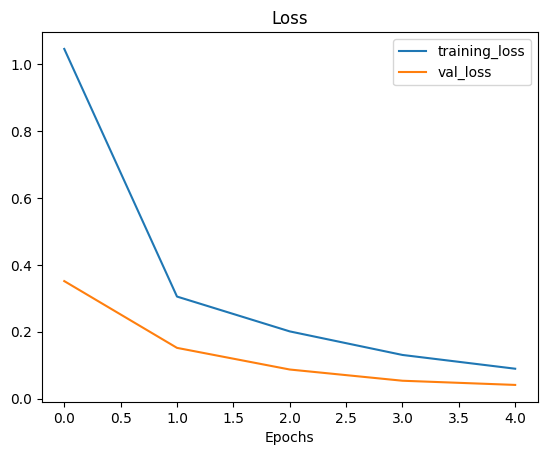

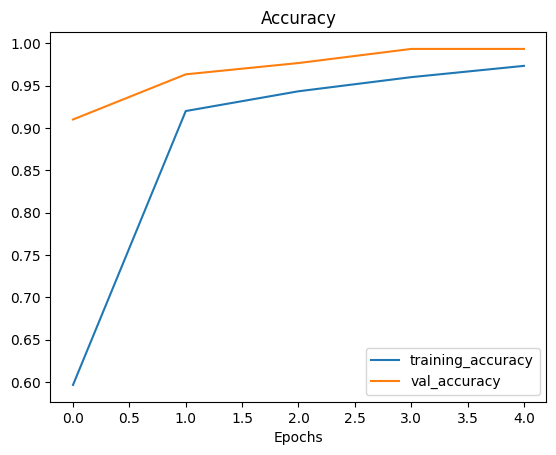

In [67]:
plot_loss_curves(history=history_resnet)

In [68]:
test_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], d

In [69]:
print(test_data.class_indices)

{'correct': 0, 'empty': 1, 'wrong': 2}


In [77]:
loss = results[0]
accuracy = results[1]
precision = results[2]
recall = results[3]
f1_score = 2 * (precision * recall) / (precision + recall) # Calculate F1 Score

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

Loss: 0.0410
Accuracy: 0.9933
Precision: 0.9933
Recall: 0.9933
F1 Score: 0.9933


In [70]:
resnet_model.save_weights('resnet_checkpoint')
resnet_model.save("resnet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [71]:
!pip install streamlit

In [72]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.901s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [73]:
!streamlit run /content/drive/MyDrive/ParkRight-master/app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.32.159.139
npx: installed 22 in 5.446s
your url is: https://twelve-streets-scream.loca.lt
